In [146]:
import pywt
import tensorflow as tf
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [2]:
node = [1,2,3,4,5,6,7,8,9,12,13]
start = datetime.datetime.strptime("2018-08-27", "%Y-%m-%d")
end = datetime.datetime.strptime("2018-9-27", "%Y-%m-%d")
date = [start + datetime.timedelta(days=x) for x in range(0, (end-start).days)]

In [143]:
def combine(data, slots=6):
    result = []
    for arr in data:
        result.append(calculate(arr, slots))
    return np.array(result)

def calculate(arr, slots):
    length = arr.shape[0]
    result = []
    for i in range(0, length, slots):
        tmp = arr[i:i + 6]
        tmp_mean = np.mean(tmp[:, 0:11], axis=0)
        tmp_median = np.median(tmp[:, 11:22], axis=0)
        tmp_max = np.max(tmp[:, 22:33], axis=0)
        tmp_min = np.min(tmp[:, 33:44], axis=0)
        tmp_wl = np.mean(tmp[:, 44:55], axis=0)
        tmp = np.hstack((tmp_mean, tmp_median, tmp_max, tmp_min, tmp_wl))
        result.append(tmp)

    return np.array(result)

def concatenate(date_list, node):
    data = []
    for date in date_list:
        if date.weekday() >= 5:
            continue
        tmp = np.load("./data/m4/" + str(date)[:10] + '_4.npy')
        if tmp.shape[0] < 286:
            continue
        data.append(tmp)
    return np.array(data)

def reconstruct(ans):
    res = []
    for r in ans[1]:
        res.append(r)
        res.append(r)
    res = np.array(res)
    return res[2: -2]

def wavelet(data):
    result = []
    for d in data:
        tmp_list = np.array([])
        for i in range(11):
            tmp = pywt.dwt(d[:, i], 'bior1.3')
            tmp = reconstruct(tmp)[2:-2]
            tmp = tmp.reshape(-1, 1)
            if i == 0:
                tmp_list = tmp
                continue
            tmp_list = np.concatenate([tmp_list, tmp], axis=1)

        result.append(tmp_list)

    return np.array(result)

def mse(pred, gt):
    return np.mean(np.square(pred - gt))

def Rsquare(pred, gt):
    length = len(pred)
    result = 0
    for i in range(length):
        result += r2_score(pred[i], gt[i])
    return result / length

In [101]:
class Data:

    def __init__(self, time, batch_size = 32):
        self.odata = concatenate(date_list=date, node=node)
        wl = wavelet(self.odata)
        self.odata = np.concatenate([self.odata, wl], axis=2)
        self.data = None
        self.data_init(miniute=5, time=10)
        self.data = combine(self.data)
        print(self.data.shape)

        self.length = len(self.data)

        self.train_len = int(self.length * 0.8)
        self.val_len = int(self.length - self.train_len)

        self.index = None
        self.train_index = None
        self.train_pos = 0
        self.val_index = None
        self.val_pos = 0
        self.batch_size = batch_size

    def data_init(self, miniute, time):
        data = self.odata
        result = []
        start = int(9 * 60 / miniute)
        for i in range(start, 286 - 42, int(time / miniute)):
            result.append(data[:, i:i + 42, :])
        self.data =  np.array(result).reshape(-1, 42, 55)
            
    def reset_index(self):
        self.index = np.arange(self.length)
        
    def shuffle_index(self):
        self.train_pos = 0
        self.val_pos = 0
        np.random.shuffle(self.index)
        self.train_index = self.index[:self.train_len]
        self.val_index = self.index[self.train_len:]

    def get_train(self):
        train = self.data[self.train_index[self.train_pos:  self.train_pos + self.batch_size]][:, 0:-1]
        label = self.data[self.train_index[self.train_pos: self.train_pos + self.batch_size]][:, 1:, 0:11]
        self.train_pos += self.batch_size
        
        return train, label

    def get_val(self):
        train = self.data[self.val_index[self.val_pos: self.val_pos + self.batch_size]][:, 0:-1]
        label = self.data[self.val_index[self.val_pos: self.val_pos + self.batch_size]][:, 1:, 0:11]
        self.val_pos += self.batch_size

        return train, label

In [102]:
a = Data(10)

(1496, 7, 55)


In [103]:
num_input = 55
num_time_step = 6
# num_neuron_per_layer = 256
num_neuron_per_layer = 512
num_layers = 1
num_output = 11
learning_rate = 0.001
nepoches = 150

tf.reset_default_graph()
X = tf.placeholder(dtype=tf.float32, shape=[None, num_time_step, num_input])
y = tf.placeholder(dtype=tf.float32, shape=[None, num_time_step, num_output])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=num_neuron_per_layer, activation=tf.nn.relu)
cell = tf.contrib.rnn.AttentionCellWrapper(cell, attn_length=6)
cell = tf.contrib.rnn.OutputProjectionWrapper(cell, num_output)

outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
loss = tf.reduce_mean(tf.square(y - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

train = optimizer.minimize(loss)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
a.reset_index()

with tf.Session() as sess:
    sess.run(init)
    f = open("log_10min_wl_512.txt", "w")
    for epoch in range(nepoches):
        iteration = a.train_len // a.batch_size
        a.shuffle_index()
        for i in range(iteration):
            x_batch, y_batch = a.get_train()
            sess.run(train, feed_dict={X:x_batch, y:y_batch})
        
        if epoch % 10 == 0:
            x_batch, y_batch = a.get_val()
            mse = loss.eval(feed_dict={X:x_batch, y:y_batch})
            print (epoch, "\tMSE:", mse)
            f.write(str(epoch) + "\tMSE:" + str(mse) + "\n")
            
            if mse < 5:
                saver.save(sess, "./RNN_MODEL_10_wl_512" + str(epoch))

    f.close()
    saver.save(sess, "./RNN_MODEL_10_att_wl_final" )

0 	MSE: 49.56087
10 	MSE: 17.234005
20 	MSE: 13.393865
30 	MSE: 11.656411
40 	MSE: 9.807116
50 	MSE: 7.2740707
60 	MSE: 6.2807436
70 	MSE: 9.337716
80 	MSE: 4.265887
90 	MSE: 3.2728252
100 	MSE: 5.229593
110 	MSE: 3.4764733
120 	MSE: 4.2358775
130 	MSE: 2.6086996
140 	MSE: 2.816071


In [70]:
pred_10_2 = np.load("./data/m4/2018-10-02_4.npy").reshape(-1, 286, 44)
pred_10_8 = np.load("./data/m4/2018-10-08_4.npy").reshape(-1, 286, 44)
pred_10_11 = np.load("./data/m4/2018-10-11_4.npy").reshape(-1, 286, 44)
pred_all = np.array([pred_10_2, pred_10_8, pred_10_11])
wl_pred = wavelet(pred_all[:, 0, :, :])
pred_all = combine(np.concatenate([pred_all[:, 0], wl_pred], axis=2))
pred_all.shape

(3, 48, 55)

In [123]:
result = []
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, "./RNN_MODEL_10_wl_512100")
    for pred in pred_all:
        pos = 18
        tmp = []
        for i in range(25):
            x_batch = pred[pos:pos + 6].reshape(1, num_time_step, 55)
            y_pred = sess.run(outputs, feed_dict={X:x_batch})
            tmp.append(y_pred[0][5])
            pos += 1
        result.append(np.array(tmp))
    np.save("result_10min_att_wl_512_100.npy", np.array(result))

INFO:tensorflow:Restoring parameters from ./RNN_MODEL_10_wl_512100


### Attention

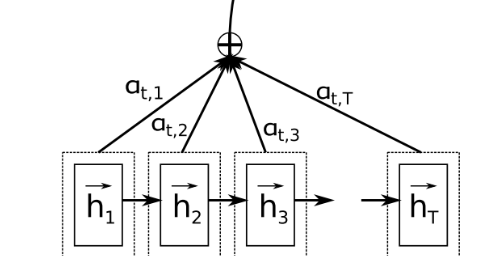

In [147]:
Image("./attention.png")

### Wavelet Transform 
(a key advantage it has over Fourier transforms is temporal resolution: it captures both frequency and location information (location in time).)

In [127]:
walet = pywt.dwt(a.odata[0, :, 0], 'bior1.3')

Text(0, 0.5, 'Population')

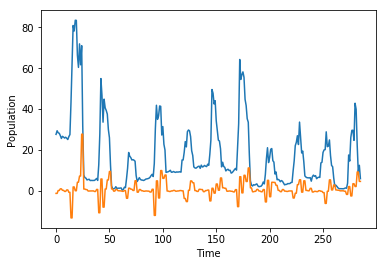

In [145]:
plt.plot(a.odata[0, :, 0])
plt.plot(reconstruct(walet))
plt.xlabel("Time")
plt.ylabel("Population")

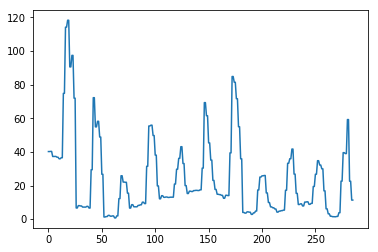

In [142]:
plt.plot(reconstruct(walet))